# Fallback Table Metalearning ANALYSIS


In [1]:
options(repr.matrix.max.cols=50, repr.matrix.max.rows=100)

In [2]:
# install.packages("pkgcond")

In [3]:
library(dplyr)
library(data.table)
library(partykit)
library(tictoc)
library(caret)
library(e1071)
library(randomForest)
library(ranger)

#for 3d plotting
library(akima)
library(plotly)

# for prep data
library(stringr)
library(pbapply)
library(stringdist)
library(data.table)
library(dominanceanalysis)


getwd()


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: grid

Loading required package: libcoin

Loading required package: mvtnorm

Loading required package: lattice

Loading required package: ggplot2

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘ranger’


The following object is masked from ‘package:randomForest’:

    importance



Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:sta

[1] "/home/jupyter/Domains_202003/scripts/phaseII_06_fallbacksupp"

In [4]:

source('../orig/functions.R')

source('../orig/functions_models.R')

source('../phaseII_03_forest/functions_eval.R')



Attaching package: ‘tidyr’


The following object is masked from ‘package:stringdist’:

    extract




In [5]:
source('functions_metalearning.R')

In [6]:
source('functions_fallback.R')

In [7]:
# source('load_prep_data_expiry_2.R') #read in train test and predictions manually instead

# READ CSV's
# expiry_df_test_preds <- read.csv("../../data/output/datapull_20201116/expiry_df_test_preds_fb.csv")
# expiry_df_train <- read.csv("../../data/output/datapull_20201116/expiry_df_train.csv")
# expiry_df_test <- read.csv("../../data/output/datapull_20201116/expiry_df_test.csv")
# metametrics_df <- read.csv("../../data/output/datapull_20201116/expiry_metametrics_df.csv")
# expiry_df
# expiry_train_df 
# expiry_test_df 
# expiry_list
# expiry_train_list
# expiry_test_list

In [8]:
dataDir='/home/jupyter/Domains_202003/data/output/datapull_20201116'

modelDir='/home/jupyter/Domains_202003/data/output/models_20201104'

outputDir='/home/jupyter/Domains_202003/data/output/datapull_20201127'

# Load meta-based predictions on new datapull

In [9]:
expiry_new_df <- readRDS(file.path(outputDir,"expiry_20200902_20201102_20201127"))
geoLookupDF <- read.csv("/home/jupyter/Domains_202003/data/input/PredictiveModelAnalysis_ResellerGeoMap.csv")

expiry_new_df <- expiry_new_df %>% filter(expiry_date < "2020-10-08")
expiry_new_df <- expiry_new_df %>% filter(!is.na(gibb_score))
expiry_new_df <- expiry_new_df %>% mutate (reg_arpt = ifelse(reg_arpt <= 0, 0.0001,reg_arpt),
                                   log_reg_arpt = log(reg_arpt),
                                   tld_registrar_index = tolower(paste(tld, reseller,sep="")))
expiry_new_df <- geo_suppl(expiry_new_df, geoLookupDF = geoLookupDF)

dim(expiry_new_df)
head(expiry_new_df)

Expiry data originally has 476586 rows and 476586 missing geo's.
... after intial merge on reseller & _country, expiry has 476586 rows and 476408 missing geo's.
... after secondary fill with _country, expiry has 476586 rows and 496 missing geo's.
... after manual tweaks with _country, expiry has 476586 rows and 71 missing geo's.


[1] 476586     33

,reseller,reseller_country,renewal_type,renewed_count,expiry_date,creation_date,status,domain_id,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,pattern,pattern_domain_count,day_domains,sld_length,sld_type,sld_type2,tld,region,log_reg_arpt,tld_registrar_index,reseller_geo
,<fct>,<fct>,<chr>,<int>,<date>,<date>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<date>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<fct>
1,1&1 Internet,Germany,FirstTime,1,2020-09-17,2019-09-17,Active,129547106,preciodeloro.online,1&1 Internet,NA,1,5,5,0,279480871,transfer,NA,Renewed,2020-01-14,25,7.19,preciodeloro,1,66,12,l,12l,online,Non China,1.609438,online1&1 internet,EU
2,1&1 Internet,Germany,FirstTime,1,2020-09-10,2018-09-10,Active,76285079,advance7.online,1&1 Internet,NA,2,30,15,0,225404981,transfer,NA,Renewed,2019-08-27,25,5.42,advance7,1,73,8,ln,8ln,online,Non China,2.708050,online1&1 internet,EU
3,1&1 Internet,Germany,FirstTime,1,2020-10-02,2019-10-02,Active,132626216,stellenanzeigen-on-demand.online,1&1 Internet,NA,1,5,5,0,323941649,renewal,NA,Renewed,2020-06-22,25,6.99,stellenanzeigen-on-demand,1,61,25,hyphen-l,25hyphen-l,online,Non China,1.609438,online1&1 internet,EU
4,1&1 Internet,Germany,FirstTime,1,2020-09-07,2019-09-07,Active,127423021,colmex.online,1&1 Internet,NA,1,5,5,0,244331895,renewal,NA,Renewed,2019-10-28,25,4.32,colmex,1,82,6,l,6l,online,Non China,1.609438,online1&1 internet,EU
5,1&1 Internet,Germany,FirstTime,1,2020-09-08,2019-09-08,Active,127588571,chattaboxforum.online,1&1 Internet,NA,1,5,5,0,229331376,renewal,NA,Renewed,2019-09-09,25,3.66,chattaboxforum,1,65,14,l,14l,online,Non China,1.609438,online1&1 internet,EU
6,1&1 Internet,Germany,FirstTime,1,2020-10-02,2019-10-02,Active,132629291,jobpodcast.online,1&1 Internet,NA,1,5,5,0,323938864,renewal,NA,Renewed,2020-06-22,25,1.96,jobpodcast,1,61,10,l,10l,online,Non China,1.609438,online1&1 internet,EU


In [10]:
expiry_new_df %>% distinct((tld_registrar_index)) %>% nrow()

[1] 1605

In [11]:
meta_preds <- read.csv(file.path(outputDir, 'meta_preds', 'meta_preds.csv'))
dim(meta_preds)
head(meta_preds)

[1] 535698     37

,X,reseller,reseller_country,renewal_type,renewed_count,expiry_date,creation_date,status,domain_id,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,pattern,pattern_domain_count,day_domains,sld_length,sld_type,sld_type2,tld,region,log_reg_arpt,tld_registrar_index,reseller_geo,actual,predicted,model
,<int>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<lgl>,<int>,<dbl>,<dbl>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<fct>
1,1,1API,Germany,Subsequent,3,2020-09-29,2017-09-29,Active,53188623,sla.fun,1API,NA,1,15,15,0,0,NA,NA,Not Renewd,NA,NA,3.06,sla,1,1,3,l,3l,fun,Non China,2.708050,fun1api,EU,Not Renewd,0.5988058,preds_agg_rf_ALL
2,2,1API,Germany,Second,2,2020-10-05,2018-10-05,Active,78340684,rodzina.fun,1API,NA,1,15,15,0,0,NA,NA,Not Renewd,NA,NA,2.09,rodzina,1,1,7,l,7l,fun,Non China,2.708050,fun1api,EU,Not Renewd,0.8564813,preds_agg_rf_ALL
3,3,Alibaba,China,Second,2,2020-09-12,2018-09-12,Active,76434689,1-zhao.fun,Alibaba,NA,1,6,6,0,331046579,renewal,NA,Renewed,2020-07-21,6,1.28,1-zhao,1,47,6,hyphen-ln,6hyphen-ln,fun,China,1.791759,funalibaba,China,Renewed,0.1398346,preds_agg_rf_ALL
4,4,Alibaba,China,Second,2,2020-09-06,2018-09-06,Active,75994739,leafapp.fun,Alibaba,NA,1,6,6,0,331771244,renewal,NA,Renewed,2020-07-24,6,4.20,leafapp,1,46,7,l,7l,fun,China,1.791759,funalibaba,China,Renewed,0.1979831,preds_agg_rf_ALL
5,5,Alibaba,China,Second,2,2020-09-24,2018-09-24,Active,77302744,icc.fun,Alibaba,NA,1,6,6,0,336522899,renewal,NA,Renewed,2020-08-11,6,3.63,icc,1,20,3,l,3l,fun,China,1.791759,funalibaba,China,Renewed,0.2805935,preds_agg_rf_ALL
6,6,Alibaba,China,Second,2,2020-09-04,2018-09-04,Active,75791344,sgzx.fun,Alibaba,NA,1,6,6,0,327584139,renewal,NA,Renewed,2020-07-07,6,0.06,sgzx,1,85,4,l,4l,fun,China,1.791759,funalibaba,China,Renewed,0.1995516,preds_agg_rf_ALL


In [12]:
meta_preds %>% distinct((tld_registrar_index)) %>% nrow()

[1] 1605

# Load model predictions on new data pull

In [13]:
fullDir=outputDir
predDir = file.path(fullDir, 'preds')
model_preds = read.csv(file.path(predDir, 'preds.csv'))
model_preds %>% head()

,reseller,reseller_country,renewal_type,renewed_count,expiry_date,creation_date,status,domain_id,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,pattern,pattern_domain_count,day_domains,sld_length,sld_type,sld_type2,tld,region,log_reg_arpt,tld_registrar_index,reseller_geo,pred_agg_glm_ALL,pred_agg_rf_ALL,pred_agg_glm,pred_agg_rf,pred_seg_glm_ALL,pred_seg_rf_ALL,pred_seg2_glm_ALL,pred_seg2_rf_ALL
,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<lgl>,<int>,<dbl>,<dbl>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1&1 Internet,Germany,FirstTime,1,2020-09-17,2019-09-17,Active,129547106,preciodeloro.online,1&1 Internet,NA,1,5,5,0,279480871,transfer,NA,Renewed,2020-01-14,25,7.19,preciodeloro,1,66,12,l,12l,online,Non China,1.609438,online1&1 internet,EU,0.588,0.5921809,0.574,0.5846861,0.554,0.5702239,0.5438008,0.5917278
2,1&1 Internet,Germany,FirstTime,1,2020-09-10,2018-09-10,Active,76285079,advance7.online,1&1 Internet,NA,2,30,15,0,225404981,transfer,NA,Renewed,2019-08-27,25,5.42,advance7,1,73,8,ln,8ln,online,Non China,2.708050,online1&1 internet,EU,0.572,0.6141844,0.562,0.6244877,0.484,0.6159490,0.4851443,0.6179782
3,1&1 Internet,Germany,FirstTime,1,2020-10-02,2019-10-02,Active,132626216,stellenanzeigen-on-demand.online,1&1 Internet,NA,1,5,5,0,323941649,renewal,NA,Renewed,2020-06-22,25,6.99,stellenanzeigen-on-demand,1,61,25,hyphen-l,25hyphen-l,online,Non China,1.609438,online1&1 internet,EU,0.552,0.5986996,0.545,0.5923937,0.586,0.6187455,0.5799558,0.6340684
4,1&1 Internet,Germany,FirstTime,1,2020-09-07,2019-09-07,Active,127423021,colmex.online,1&1 Internet,NA,1,5,5,0,244331895,renewal,NA,Renewed,2019-10-28,25,4.32,colmex,1,82,6,l,6l,online,Non China,1.609438,online1&1 internet,EU,0.602,0.4743705,0.586,0.4799012,0.578,0.4853137,0.5700971,0.4702835
5,1&1 Internet,Germany,FirstTime,1,2020-09-08,2019-09-08,Active,127588571,chattaboxforum.online,1&1 Internet,NA,1,5,5,0,229331376,renewal,NA,Renewed,2019-09-09,25,3.66,chattaboxforum,1,65,14,l,14l,online,Non China,1.609438,online1&1 internet,EU,0.568,0.4919164,0.553,0.4825344,0.554,0.4803202,0.5428917,0.4597726
6,1&1 Internet,Germany,FirstTime,1,2020-10-02,2019-10-02,Active,132629291,jobpodcast.online,1&1 Internet,NA,1,5,5,0,323938864,renewal,NA,Renewed,2020-06-22,25,1.96,jobpodcast,1,61,10,l,10l,online,Non China,1.609438,online1&1 internet,EU,0.582,0.6497964,0.566,0.6369012,0.571,0.5675839,0.5590710,0.6092187


In [14]:
model_preds %>% distinct((tld_registrar_index)) %>% nrow()

[1] 1605

# join Preds

In [15]:
preds_all <- inner_join(meta_preds %>% select(domain_id, model, predicted) %>% rename(model_meta = model, pred_meta = predicted), 
                        model_preds,
                        by='domain_id')
dim(meta_preds)
dim(model_preds)
dim(preds_all)

[1] 535698     37

[1] 476586     41

[1] 535698     43

In [16]:
dim(preds_all) - dim(model_preds)

[1] 59112     2

# Verify data integrity

In [17]:
preds_all %>%
  select(everything()) %>%  # replace to your needs
  summarise_all(funs(sum(is.na(.)))) %>%
  t()

Warning message:
“`funs()` is deprecated as of dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


domain_id,0
model_meta,0
pred_meta,1126
reseller,0
reseller_country,0
renewal_type,0
renewed_count,0
expiry_date,0
creation_date,0
status,0
domain,0


In [18]:
meta_preds_tldre_count <- meta_preds %>% group_by(tld_registrar_index) %>% tally()
meta_preds_tldre_count %>% arrange(desc(n)) %>% head()

tld_registrar_index,n
<fct>,<int>
funalibaba,53324
spacealibaba,38716
sitegmo,34803
websitealibaba,25010
sitenamecheap,20337
sitereg.ru,13284


In [19]:
expiry_new_tldre_count <- expiry_new_df %>% group_by(tld_registrar_index) %>% tally() 
expiry_new_tldre_count$tld_registrar_index <- as.character(expiry_new_tldre_count$tld_registrar_index)
expiry_new_tldre_count %>% arrange(desc(n)) %>% head()

tld_registrar_index,n
<chr>,<int>
funalibaba,53324
sitegmo,34803
sitenamecheap,20337
spacealibaba,19358
sitereg.ru,13284
onlinego daddy,12936


In [20]:
join_tldre_count <- left_join(meta_preds_tldre_count, expiry_new_tldre_count,
           by='tld_registrar_index') 

join_tldre_count %>% arrange(desc(n.x)) %>% head()

tld_registrar_index,n.x,n.y
<chr>,<int>,<int>
funalibaba,53324,53324
spacealibaba,38716,19358
sitegmo,34803,34803
websitealibaba,25010,12505
sitenamecheap,20337,20337
sitereg.ru,13284,13284


In [21]:
join_tldre_count <- join_tldre_count %>% mutate(missing_preds =n.x-n.y)
join_tldre_count %>% arrange(desc(missing_preds)) %>% filter((missing_preds)>0) 

tld_registrar_index,n.x,n.y,missing_preds
<chr>,<int>,<int>,<int>
spacealibaba,38716,19358,19358
websitealibaba,25010,12505,12505
storeshopify,3528,1764,1764
spacehostinger,1634,817,817
techdomain.com - registrar,1498,749,749
pwregway,1462,731,731
onlinetimeweb,1440,720,720
onlinetenten,1258,629,629
onlinenics telekom,1104,552,552


In [22]:
sum(join_tldre_count$missing_preds)

[1] 59112

In [23]:
# did we forget to exclude obs that are too green? NO
preds_all$ expiry_date <- as.Date(preds_all$ expiry_date)
preds_all %>% filter(expiry_date >= "2020-10-08")

domain_id,model_meta,pred_meta,reseller,reseller_country,renewal_type,renewed_count,expiry_date,creation_date,status,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,pattern,pattern_domain_count,day_domains,sld_length,sld_type,sld_type2,tld,region,log_reg_arpt,tld_registrar_index,reseller_geo,pred_agg_glm_ALL,pred_agg_rf_ALL,pred_agg_glm,pred_agg_rf,pred_seg_glm_ALL,pred_seg_rf_ALL,pred_seg2_glm_ALL,pred_seg2_rf_ALL
<int>,<fct>,<dbl>,<fct>,<fct>,<fct>,<int>,<date>,<fct>,<fct>,<fct>,<fct>,<lgl>,<int>,<dbl>,<dbl>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


In [24]:
# did we forget to exclude obs w/ NA gibbscore?? NO
preds_all %>% filter(is.na(gibb_score))

domain_id,model_meta,pred_meta,reseller,reseller_country,renewal_type,renewed_count,expiry_date,creation_date,status,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,pattern,pattern_domain_count,day_domains,sld_length,sld_type,sld_type2,tld,region,log_reg_arpt,tld_registrar_index,reseller_geo,pred_agg_glm_ALL,pred_agg_rf_ALL,pred_agg_glm,pred_agg_rf,pred_seg_glm_ALL,pred_seg_rf_ALL,pred_seg2_glm_ALL,pred_seg2_rf_ALL
<int>,<fct>,<dbl>,<fct>,<fct>,<fct>,<int>,<date>,<fct>,<fct>,<fct>,<fct>,<lgl>,<int>,<dbl>,<dbl>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


In [25]:
preds_all %>% filter(is.na(pred_meta)) %>% nrow()

[1] 1126

In [26]:
preds_all %>% filter(is.na(pred_agg_rf_ALL)) %>% nrow()

[1] 0

# Backfill pred_meta with available model preds

In [27]:
# all missing obs ... pertain to seg2_glm
preds_all %>% filter(is.na(pred_meta)) %>% select(model_meta) %>% table()
# all missing obs ... have agg_rf predictions availale
preds_all %>% filter(is.na(pred_meta)) %>% select(contains('pred')) %>% summarise_all(funs(sum(is.na(.))))
# ... so backfill with agg_rf predictions

.
  preds_agg_rf_ALL preds_seg2_glm_ALL  preds_seg2_glm_fb 
                 0               1126                  0 

pred_meta,pred_agg_glm_ALL,pred_agg_rf_ALL,pred_agg_glm,pred_agg_rf,pred_seg_glm_ALL,pred_seg_rf_ALL,pred_seg2_glm_ALL,pred_seg2_rf_ALL
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1126,67,0,718,0,187,114,1126,189


In [28]:
preds_all <- preds_all %>% mutate(pred_meta_bf = ifelse(is.na(pred_meta),pred_agg_rf_ALL, pred_meta))

In [29]:
preds_all %>% filter(is.na(pred_meta)) %>% select(pred_meta, pred_meta_bf, pred_agg_rf_ALL) %>% head()

,pred_meta,pred_meta_bf,pred_agg_rf_ALL
,<dbl>,<dbl>,<dbl>
1,NA,0.5336472,0.5336472
2,NA,0.8064000,0.8064000
3,NA,0.2499400,0.2499400
4,NA,0.5055587,0.5055587
5,NA,0.1598732,0.1598732
6,NA,0.1678168,0.1678168


In [30]:
# for all obs where pred_mate is na, are any pred_meta_bf != pred_agg_rf_ALL NOPE
preds_all %>% filter(is.na(pred_meta)) %>% select(pred_meta, pred_meta_bf, pred_agg_rf_ALL) %>% summarize(sum(pred_meta_bf!=pred_agg_rf_ALL))

sum(pred_meta_bf != pred_agg_rf_ALL)
<int>
0


# Apply fallback to seg2_glm preds

In [31]:
# read in training data
expiry_df_train <- read.csv("../../data/output/datapull_20201116/expiry_df_train.csv")
expiry_df_train_g <- geo_suppl(expiry_df_train, geoLookupDF = geoLookupDF)
# generate list of fallback tables
npv_fallback_list = fallback_gen( npv_historic_renewal_data = expiry_df_train_g, 
                                 reseller_am_geo_map = geoLookupDF)
names(npv_fallback_list)
for(i in 1:length(npv_fallback_list)) assign(names(npv_fallback_list)[i], npv_fallback_list[[i]])

Expiry data originally has 3729384 rows and 3729384 missing geo's.
... after intial merge on reseller & _country, expiry has 3729384 rows and 3726455 missing geo's.
... after secondary fill with _country, expiry has 3729384 rows and 6983 missing geo's.
... after manual tweaks with _country, expiry has 3729384 rows and 29 missing geo's.


`summarise()` regrouping output by 'tld', 'reseller_geo' (override with `.groups` argument)

`summarise()` regrouping output by 'reseller_geo' (override with `.groups` argument)

`summarise()` regrouping output by 'tld' (override with `.groups` argument)

`summarise()` regrouping output by 'tld' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` regrouping output by 'tld' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` regrouping output by 'region' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



[1] "npv_fallback_first_geo_arpt_tld" "npv_fallback_first_geo_arpt"    
 [3] "npv_fallback_first_tld_arpt"     "npv_fallback_second_tld_geo"    
 [5] "npv_fallback_second_geo"         "npv_fallback_third_tld_geo"     
 [7] "npv_fallback_third_geo"          "npv_fallback_first_final"       
 [9] "npv_fallback_second_final"       "npv_fallback_third_final"

In [33]:
# generate list of low-volume tld-re's from training data
tld_registrar_excl_list = tld_registrar_excl_df(expiry_df_train_g)
# generate placeholder columns in preds df for fall backapp
# ... where predictions for low-volume tld-registrars are NA
preds_all <- preds_all %>%
     mutate( across(contains('pred_'), 
                    .fns = list(fb = ~ifelse(tld_registrar_index %in% tld_registrar_excl_list, NA, . )) ))

Excluding 1706 tld-re's (80.89%), due to volume < 500 
Excluding 157 tld-re's (7.44%) associated with tld's 'pw' and 'in.net' 


In [34]:
preds_all %>% select(contains('pred_')) %>% head()

,pred_meta,pred_agg_glm_ALL,pred_agg_rf_ALL,pred_agg_glm,pred_agg_rf,pred_seg_glm_ALL,pred_seg_rf_ALL,pred_seg2_glm_ALL,pred_seg2_rf_ALL,pred_meta_bf,pred_meta_fb,pred_agg_glm_ALL_fb,pred_agg_rf_ALL_fb,pred_agg_glm_fb,pred_agg_rf_fb,pred_seg_glm_ALL_fb,pred_seg_rf_ALL_fb,pred_seg2_glm_ALL_fb,pred_seg2_rf_ALL_fb,pred_meta_bf_fb
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.5988058,0.438,0.5988058,NA,0.6346318,0.778,0.6171213,0.778650516,0.3910589,0.5988058,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,0.8564813,0.416,0.8564813,NA,0.6121264,0.749,0.7058457,0.816886319,0.6241285,0.8564813,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,0.1398346,0.042,0.1398346,0.039,0.1391479,0.026,0.3133168,0.001886783,0.3663035,0.1398346,0.1398346,0.042,0.1398346,0.039,0.1391479,0.026,0.3133168,0.001886783,0.3663035,0.1398346
4,0.1979831,0.077,0.1979831,0.069,0.1725707,0.135,0.2721024,0.100167528,0.3821253,0.1979831,0.1979831,0.077,0.1979831,0.069,0.1725707,0.135,0.2721024,0.100167528,0.3821253,0.1979831
5,0.2805935,0.084,0.2805935,0.075,0.2683628,0.167,0.3523074,0.145996585,0.4215242,0.2805935,0.2805935,0.084,0.2805935,0.075,0.2683628,0.167,0.3523074,0.145996585,0.4215242,0.2805935
6,0.1995516,0.074,0.1995516,0.066,0.2223433,0.142,0.2626757,0.112936327,0.2879022,0.1995516,0.1995516,0.074,0.1995516,0.066,0.2223433,0.142,0.2626757,0.112936327,0.2879022,0.1995516


In [35]:
# apply fallback tables TST
preds_all <- geo_suppl(preds_all, geoLookupDF = geoLookupDF)
    
preds_all <- fallback_app_1(test_data_op=preds_all,
               in_col='pred_seg2_rf_ALL_fb',
               out_col='pred_seg2_rf_ALL_fb')
preds_all <- fallback_app_1(test_data_op=preds_all,
               in_col='pred_seg2_glm_ALL_fb',
               out_col='pred_seg2_glm_ALL_fb')

preds_all <- fallback_app_1(test_data_op=preds_all,
               in_col='pred_seg_rf_ALL_fb',
               out_col='pred_seg_rf_ALL_fb')
preds_all <- fallback_app_1(test_data_op=preds_all,
               in_col='pred_seg_glm_ALL_fb',
               out_col='pred_seg_glm_ALL_fb')

preds_all <- fallback_app_1(test_data_op=preds_all,
               in_col='pred_agg_rf_fb',
               out_col='pred_agg_rf_fb')
preds_all <- fallback_app_1(test_data_op=preds_all,
               in_col='pred_agg_glm_fb',
               out_col='pred_agg_glm_fb')

preds_all <- fallback_app_1(test_data_op=preds_all,
               in_col='pred_agg_rf_ALL_fb',
               out_col='pred_agg_rf_ALL_fb')
preds_all <- fallback_app_1(test_data_op=preds_all,
               in_col='pred_agg_glm_ALL_fb',
               out_col='pred_agg_glm_ALL_fb')

# performance if we backfill all NAs and low-volume meta-based NAs (no agg_rf used) with fallback values
preds_all <- fallback_app_1(test_data_op=preds_all,
               in_col='pred_meta_fb',
               out_col='pred_meta_fb2')

# performance if we backfill meta-based NAs with fallback values intead of agg_rf
preds_all <- fallback_app_1(test_data_op=preds_all,
               in_col='pred_meta',
               out_col='pred_meta_fb1')




Expiry data originally has 535698 rows and 535698 missing geo's.
... after intial merge on reseller & _country, expiry has 535698 rows and 122 missing geo's.
... after secondary fill with _country, expiry has 535698 rows and 122 missing geo's.
... after manual tweaks with _country, expiry has 535698 rows and 122 missing geo's.


In [36]:
preds_all %>%
  select(contains('pred')) %>% 
  summarise_all(funs(sum(is.na(.)))) %>% t()

pred_meta,1126
pred_agg_glm_ALL,118
pred_agg_rf_ALL,0
pred_agg_glm,11830
pred_agg_rf,0
pred_seg_glm_ALL,278
pred_seg_rf_ALL,187
pred_seg2_glm_ALL,1514
pred_seg2_rf_ALL,288
pred_meta_bf,0
pred_meta_fb,57340


In [37]:
preds_all %>%
  select(contains('pred')) %>% 
  names()

[1] "pred_meta"            "pred_agg_glm_ALL"     "pred_agg_rf_ALL"     
 [4] "pred_agg_glm"         "pred_agg_rf"          "pred_seg_glm_ALL"    
 [7] "pred_seg_rf_ALL"      "pred_seg2_glm_ALL"    "pred_seg2_rf_ALL"    
[10] "pred_meta_bf"         "pred_meta_fb"         "pred_agg_glm_ALL_fb" 
[13] "pred_agg_rf_ALL_fb"   "pred_agg_glm_fb"      "pred_agg_rf_fb"      
[16] "pred_seg_glm_ALL_fb"  "pred_seg_rf_ALL_fb"   "pred_seg2_glm_ALL_fb"
[19] "pred_seg2_rf_ALL_fb"  "pred_meta_bf_fb"      "pred_meta_fb2"       
[22] "pred_meta_fb1"

# Evaluate perfromance

In [38]:

lift_list <- list()
auc_list <- list()

fallback_lift <- chart_lift(pred_df=preds_all,
                        dep_var = "renewal_status",
                        pred_var = "pred_meta") 

lift_list[["meta-based"]] <- fallback_lift
auc_list[["meta-based"]] <- calc_auc(lift_df=fallback_lift)

models <- c('pred_agg_glm_ALL','pred_agg_rf_ALL','pred_agg_glm','pred_agg_rf',
            'pred_seg_glm_ALL','pred_seg_rf_ALL','pred_seg2_glm_ALL','pred_seg2_rf_ALL',
            'pred_meta_bf', # meta-based preds, NA's backfilled with agg_rf values
            'pred_agg_glm_ALL_fb','pred_agg_rf_ALL_fb','pred_agg_glm_fb','pred_agg_rf_fb',
            'pred_seg_glm_ALL_fb','pred_seg_rf_ALL_fb','pred_seg2_glm_ALL_fb','pred_seg2_rf_ALL_fb',
            'pred_meta_fb2', # meta-based preds, NA's backfilled with fallback values
            'pred_meta_fb1' # meta-based preds, NAs and low-volume backfilled with fallback values
           )


for (model in models){
    model_lift <- chart_lift(pred_df=preds_all,
                        dep_var = "renewal_status",
                        pred_var = model) 
    
    fallback_lift <- merge(fallback_lift, model_lift, by=c("P"),all= TRUE, 
                           suffixes = c("",
                                        paste("_",gsub("pred_df_", "", model)) ))
    
    lift_list[[model]] <- model_lift
    auc_list[[model]] <- calc_auc(lift_df=model_lift)
}

lift_df <- fallback_lift


In [39]:
prop.table(table(preds_all$renewal_status))


Not Renewd    Renewed 
0.91768123 0.08231877 

In [40]:
plot_multigains <- function (lift_df_list=list(metamodel = fallback_lift),
                             auc_list = list(metamodel = calc_auc(lift_df=fallback_lift)),
                             prop_positive = 0.08231877 ) {
  
  optimal_df <- data.frame( "P"=c(0,prop_positive,1.0),
                            "actu_renwd2"=c(NA,NA,NA),
                            "gain"=c(0,1.0,1.0),
                            "lift"=c(NA,NA,NA))
  
  lift_df_list <- lapply(lift_df_list, function(df) {
    df <- df %>%
      add_row(P = 0, gain =0) %>%
      arrange(P)
  })

  auc_lift_list = paste(lapply(auc_list, round, 3),sapply(lift_df_list, function(x) round(x[2,"lift"],2)), sep=", ")
  
  auc_map = paste(names(lift_df_list),auc_lift_list, sep=" = ")[1:length(lift_df_list)]
  
  
  gains_plot <- ggplot(NULL, aes(P,  gain)) +
    geom_line(data = lift_df_list[[1]] %>% slice(1, n())) +
    
    list(geom_line(data=optimal_df), geom_point(data=optimal_df)) +
    
    scale_y_continuous(breaks = seq(0, 1, by = .1), limits = c(0,1)) +
    scale_x_continuous(breaks = seq(0, 1, by = .1)) +
    labs(title = "Cumulative Gains Plot",
         y = "Cumulative Gain",
         x = "Percentile")+
    theme(text = element_text(size=20))
  
  for(i in seq(length(lift_df_list))){
    name = names(lift_df_list)[[i]]
    df = lift_df_list[[i]]
    auc = auc_list[[i]]
    gains_plot <- gains_plot + list(geom_line(data=df), 
                                    geom_point(data=df))+ 
      annotate("text", x = .4, y = .9-i*.075, hjust = 0, label = auc_map[[i]], size = 5)
  }
  
  
  return(gains_plot)
}


Warning message:
“Removed 1 rows containing missing values (geom_text).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”


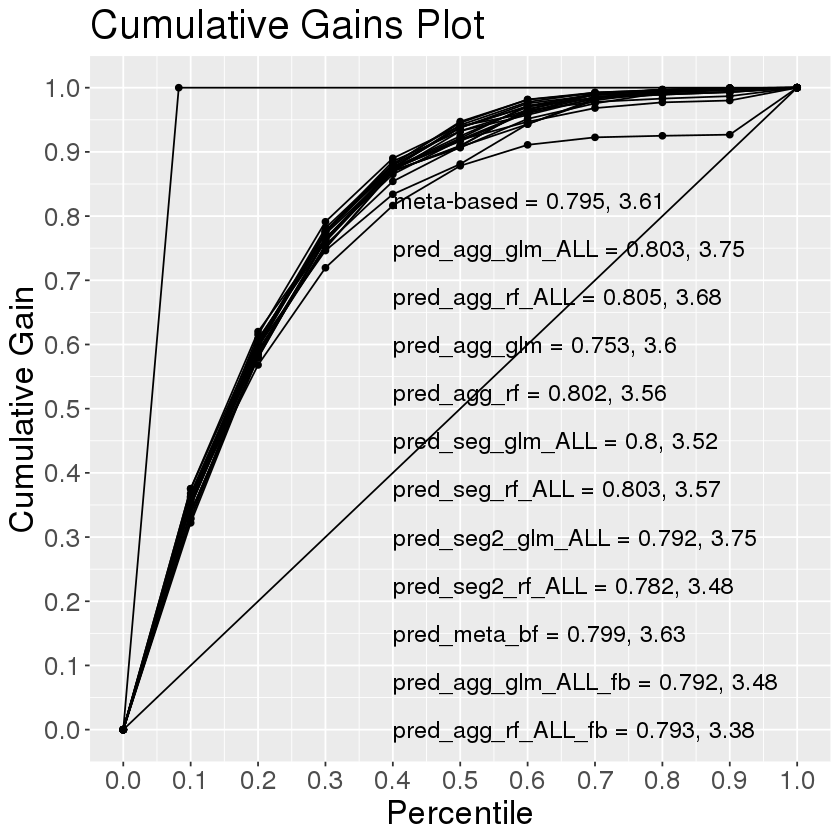

In [41]:
plot_multigains(            lift_df_list=lift_list,
                             auc_list = auc_list,
                             prop_positive = 0.08231877 ) 

In [42]:
lift_df_10 <- lift_df %>% filter(P==0.1) %>% select(contains("lift_")) %>% t
df <- as.data.frame(as.data.frame(lift_df_10))
df %>% arrange(desc(V1))

,V1
,<dbl>
lift_ pred_agg_glm_ALL,3.754139
lift_ pred_seg2_glm_ALL,3.752551
lift_ pred_agg_rf_ALL,3.679532
lift_ pred_meta_bf,3.631911
lift_ pred_meta_fb1,3.627829
lift_ pred_agg_glm,3.596081
lift_ pred_seg_rf_ALL,3.566602
lift_ pred_agg_rf,3.555037
lift_ pred_seg_glm_ALL,3.517166


In [43]:
# 3.36% improvement in performance of meta based predictions NAs backfilled with agg_rf over backfilled seg2_glm
(lift_df_10['lift_ pred_meta_bf',]-lift_df_10['lift_ pred_seg2_glm_ALL_fb',])/lift_df_10['lift_ pred_seg2_glm_ALL_fb',]

lift_ pred_meta_bf 
        0.03362375

In [44]:
# 4.7% improvement in performance of agg_rf over backfilled seg2_glm
(lift_df_10['lift_ pred_agg_rf_ALL',]-lift_df_10['lift_ pred_seg2_glm_ALL_fb',])/lift_df_10['lift_ pred_seg2_glm_ALL_fb',]

lift_ pred_agg_rf_ALL 
           0.04717651

In [45]:
df <- as.data.frame(as.data.frame(as.data.frame(auc_list)) %>% t())
df %>% arrange(desc(V1))

,V1
,<dbl>
pred_agg_rf_ALL,0.8046351
pred_seg_rf_ALL,0.8030500
pred_agg_glm_ALL,0.8028913
pred_agg_rf,0.8022654
pred_seg_glm_ALL,0.7995283
pred_meta_bf,0.7990453
pred_meta_fb1,0.7988662
pred_seg_rf_ALL_fb,0.7959907
meta.based,0.7945666


In [46]:
# improvement in performance of meta_bf over seg2_glm_fb - auc
auc_list$pred_meta_bf
auc_list$pred_seg2_glm_ALL_fb
(auc_list$pred_meta_bf-auc_list$pred_seg2_glm_ALL_fb)/(auc_list$pred_seg2_glm_ALL_fb)

[1] 0.7990453

[1] 0.7912762

[1] 0.009818391

In [47]:
# improvement in performance of agg_rf over seg2_glm_fb - auc
auc_list$pred_agg_rf_ALL
auc_list$pred_seg2_glm_ALL_fb
(auc_list$pred_agg_rf_ALL-auc_list$pred_seg2_glm_ALL_fb)/(auc_list$pred_seg2_glm_ALL_fb)

[1] 0.8046351

[1] 0.7912762

[1] 0.0168827

In [ ]:
# # agg_rf vs. seg2_glm Sensitivity & Specificity at cutoff of .5 and =proppos
# compare_df = as.data.frame(list('agg_rf_0.089'=confusionMatrix(as.factor(ifelse(preds_df$pred_agg_rf_ALL > 0.08937016, "Renewed", "Not Renewd")), 
#                 preds_df$renewal_status, positive="Renewed")$byClass,
#                   'seg2_glm_fb_0.089'=confusionMatrix(as.factor(ifelse(preds_df$pred_seg2_glm_ALL_fb2 > 0.08937016, "Renewed", "Not Renewd")), 
#                 preds_df$renewal_status, positive="Renewed")$byClass,
#               'agg_rf_0.500'=confusionMatrix(as.factor(ifelse(preds_df$pred_agg_rf_ALL > 0.5, "Renewed", "Not Renewd")), 
#                 preds_df$renewal_status, positive="Renewed")$byClass,
#                   'seg2_glm_fb_0.500'=confusionMatrix(as.factor(ifelse(preds_df$pred_seg2_glm_ALL_fb2 > 0.5, "Renewed", "Not Renewd")), 
#                 preds_df$renewal_status, positive="Renewed")$byClass))
# compare_df

In [ ]:
# (0.86437281-0.80430608)/0.80430608
# (0.25372042-0.18124430)/0.18124430

In [ ]:
# # improvement in accuracy for agg_rf vs. seg2_glm (NOT REPORTED -- not appropriate for imbal data)
# (compare_df['Sensitivity','agg_rf_0.089']-compare_df['Sensitivity','seg2_glm_fb_0.089'])/compare_df['Sensitivity','seg2_glm_fb_0.089']
# compare_df = as.data.frame(list(
#     'agg_rf_0.089'=confusionMatrix(as.factor(ifelse(preds_df$pred_agg_rf_ALL > 0.08937016, "Renewed", "Not Renewd")), 
#                 preds_df$renewal_status, positive="Renewed")$overall['Accuracy'],
#                   'seg2_glm_fb_0.089'=confusionMatrix(as.factor(ifelse(preds_df$pred_seg2_glm_ALL_fb2 > 0.08937016, "Renewed", "Not Renewd")), 
#                 preds_df$renewal_status, positive="Renewed")$overall['Accuracy'],
#               'agg_rf_0.500'=confusionMatrix(as.factor(ifelse(preds_df$pred_agg_rf_ALL > 0.5, "Renewed", "Not Renewd")), 
#                 preds_df$renewal_status, positive="Renewed")$overall['Accuracy'],
#                   'seg2_glm_fb_0.500'=confusionMatrix(as.factor(ifelse(preds_df$pred_seg2_glm_ALL_fb2 > 0.5, "Renewed", "Not Renewd")), 
#                 preds_df$renewal_status, positive="Renewed")$overall['Accuracy']))
# compare_df

In [ ]:
# (0.795-0.792)/0.792

# FUP for Parag: 
## tabular (& visual) representation -- which registrars, which model (reseller priority level) 
## also performance metrics, see below (but that may be for the following Th)

### 1. Tabular

In [48]:
names(preds_all)
head(preds_all)

[1] "reseller"             "reseller_country"     "reseller_geo"        
 [4] "domain_id"            "model_meta"           "pred_meta"           
 [7] "renewal_type"         "renewed_count"        "expiry_date"         
[10] "creation_date"        "status"               "domain"              
[13] "registrar"            "registrant_country"   "reg_period"          
[16] "reg_revenue"          "reg_arpt"             "renew_mbg"           
[19] "renewal_item_id"      "renew_type"           "autorenew_type"      
[22] "renewal_status"       "renew_date"           "renew_arpt"          
[25] "gibb_score"           "pattern"              "pattern_domain_count"
[28] "day_domains"          "sld_length"           "sld_type"            
[31] "sld_type2"            "tld"                  "region"              
[34] "log_reg_arpt"         "tld_registrar_index"  "pred_agg_glm_ALL"    
[37] "pred_agg_rf_ALL"      "pred_agg_glm"         "pred_agg_rf"         
[40] "pred_seg_glm_ALL"     "pred_seg_rf_ALL"      "pred_seg2_glm_ALL"   
[43] "pred_seg2_rf_ALL"     "pred_meta_bf"         "pred_meta_fb"        
[46] "pred_agg_glm_ALL_fb"  "pred_agg_rf_ALL_fb"   "pred_agg_glm_fb"     
[49] "pred_agg_rf_fb"       "pred_seg_glm_ALL_fb"  "pred_seg_rf_ALL_fb"  
[52] "pred_seg2_glm_ALL_fb" "pred_seg2_rf_ALL_fb"  "pred_meta_bf_fb"     
[55] "reg_arpt_org"         "reg_arpt_slab"        "pred_meta_fb2"       
[58] "pred_meta_fb1"

,reseller,reseller_country,reseller_geo,domain_id,model_meta,pred_meta,renewal_type,renewed_count,expiry_date,creation_date,status,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,⋯,log_reg_arpt,tld_registrar_index,pred_agg_glm_ALL,pred_agg_rf_ALL,pred_agg_glm,pred_agg_rf,pred_seg_glm_ALL,pred_seg_rf_ALL,pred_seg2_glm_ALL,pred_seg2_rf_ALL,pred_meta_bf,pred_meta_fb,pred_agg_glm_ALL_fb,pred_agg_rf_ALL_fb,pred_agg_glm_fb,pred_agg_rf_fb,pred_seg_glm_ALL_fb,pred_seg_rf_ALL_fb,pred_seg2_glm_ALL_fb,pred_seg2_rf_ALL_fb,pred_meta_bf_fb,reg_arpt_org,reg_arpt_slab,pred_meta_fb2,pred_meta_fb1
,<fct>,<fct>,<fct>,<int>,<fct>,<dbl>,<fct>,<int>,<date>,<fct>,<fct>,<fct>,<fct>,<lgl>,<int>,<dbl>,<dbl>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,⋯,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
1,1&1 Internet,Germany,EU,129547106,preds_agg_rf_ALL,0.5921809,FirstTime,1,2020-09-17,2019-09-17,Active,preciodeloro.online,1&1 Internet,NA,1,5,5,0,279480871,transfer,NA,Renewed,2020-01-14,25,7.19,⋯,1.609438,online1&1 internet,0.588,0.5921809,0.574,0.5846861,0.554,0.5702239,0.5438008,0.5917278,0.5921809,0.5921809,0.588,0.5921809,0.574,0.5846861,0.554,0.5702239,0.5438008,0.5917278,0.5921809,5,"(3,5]",0.5921809,0.5921809
2,1&1 Internet,Germany,EU,76285079,preds_agg_rf_ALL,0.6141844,FirstTime,1,2020-09-10,2018-09-10,Active,advance7.online,1&1 Internet,NA,2,30,15,0,225404981,transfer,NA,Renewed,2019-08-27,25,5.42,⋯,2.708050,online1&1 internet,0.572,0.6141844,0.562,0.6244877,0.484,0.6159490,0.4851443,0.6179782,0.6141844,0.6141844,0.572,0.6141844,0.562,0.6244877,0.484,0.6159490,0.4851443,0.6179782,0.6141844,15,"(10,15]",0.6141844,0.6141844
3,1&1 Internet,Germany,EU,132626216,preds_agg_rf_ALL,0.5986996,FirstTime,1,2020-10-02,2019-10-02,Active,stellenanzeigen-on-demand.online,1&1 Internet,NA,1,5,5,0,323941649,renewal,NA,Renewed,2020-06-22,25,6.99,⋯,1.609438,online1&1 internet,0.552,0.5986996,0.545,0.5923937,0.586,0.6187455,0.5799558,0.6340684,0.5986996,0.5986996,0.552,0.5986996,0.545,0.5923937,0.586,0.6187455,0.5799558,0.6340684,0.5986996,5,"(3,5]",0.5986996,0.5986996
4,1&1 Internet,Germany,EU,127423021,preds_agg_rf_ALL,0.4743705,FirstTime,1,2020-09-07,2019-09-07,Active,colmex.online,1&1 Internet,NA,1,5,5,0,244331895,renewal,NA,Renewed,2019-10-28,25,4.32,⋯,1.609438,online1&1 internet,0.602,0.4743705,0.586,0.4799012,0.578,0.4853137,0.5700971,0.4702835,0.4743705,0.4743705,0.602,0.4743705,0.586,0.4799012,0.578,0.4853137,0.5700971,0.4702835,0.4743705,5,"(3,5]",0.4743705,0.4743705
5,1&1 Internet,Germany,EU,127588571,preds_agg_rf_ALL,0.4919164,FirstTime,1,2020-09-08,2019-09-08,Active,chattaboxforum.online,1&1 Internet,NA,1,5,5,0,229331376,renewal,NA,Renewed,2019-09-09,25,3.66,⋯,1.609438,online1&1 internet,0.568,0.4919164,0.553,0.4825344,0.554,0.4803202,0.5428917,0.4597726,0.4919164,0.4919164,0.568,0.4919164,0.553,0.4825344,0.554,0.4803202,0.5428917,0.4597726,0.4919164,5,"(3,5]",0.4919164,0.4919164
6,1&1 Internet,Germany,EU,132629291,preds_agg_rf_ALL,0.6497964,FirstTime,1,2020-10-02,2019-10-02,Active,jobpodcast.online,1&1 Internet,NA,1,5,5,0,323938864,renewal,NA,Renewed,2020-06-22,25,1.96,⋯,1.609438,online1&1 internet,0.582,0.6497964,0.566,0.6369012,0.571,0.5675839,0.5590710,0.6092187,0.6497964,0.6497964,0.582,0.6497964,0.566,0.6369012,0.571,0.5675839,0.5590710,0.6092187,0.6497964,5,"(3,5]",0.6497964,0.6497964


In [49]:
vis_df <- preds_all
# add reseller priority columns to metalearning predictions
priorityLookup_df <- read.csv("/home/jupyter/Domains_202003/data/data_input/PredictiveModelAnalysis_ResellerPriorityList.csv")
names(priorityLookup_df) <- c("market","reseller","npv2020","priority")
priorityLookup_df$reseller <- tolower(priorityLookup_df$reseller)
vis_df$reseller <- tolower(vis_df$reseller)
vis_df <- merge(vis_df, priorityLookup_df, by="reseller", all.x=TRUE)



dim(vis_df)
head(vis_df)

[1] 535698     61

,reseller,reseller_country,reseller_geo,domain_id,model_meta,pred_meta,renewal_type,renewed_count,expiry_date,creation_date,status,domain,registrar,registrant_country,reg_period,reg_revenue,reg_arpt,renew_mbg,renewal_item_id,renew_type,autorenew_type,renewal_status,renew_date,renew_arpt,gibb_score,⋯,pred_agg_rf_ALL,pred_agg_glm,pred_agg_rf,pred_seg_glm_ALL,pred_seg_rf_ALL,pred_seg2_glm_ALL,pred_seg2_rf_ALL,pred_meta_bf,pred_meta_fb,pred_agg_glm_ALL_fb,pred_agg_rf_ALL_fb,pred_agg_glm_fb,pred_agg_rf_fb,pred_seg_glm_ALL_fb,pred_seg_rf_ALL_fb,pred_seg2_glm_ALL_fb,pred_seg2_rf_ALL_fb,pred_meta_bf_fb,reg_arpt_org,reg_arpt_slab,pred_meta_fb2,pred_meta_fb1,market,npv2020,priority
,<chr>,<fct>,<fct>,<int>,<fct>,<dbl>,<fct>,<int>,<date>,<fct>,<fct>,<fct>,<fct>,<lgl>,<int>,<dbl>,<dbl>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<int>,<int>
1,1&1 internet,Germany,EU,126777746,preds_agg_rf_ALL,0.5564382,FirstTime,1,2020-09-05,2019-09-05,Active,xn--vila-4na.online,1&1 Internet,NA,1,0,0.0001,0,328863684,renewal,NA,Renewed,2020-07-12,25,3.10,⋯,0.5564382,0.581,0.5428296,0.556,0.5435583,0.5583280,0.5613001,0.5564382,0.5564382,0.567,0.5564382,0.581,0.5428296,0.556,0.5435583,0.5583280,0.5613001,0.5564382,0.0001,"(0,0.3]",0.5564382,0.5564382,Europe,770943,1
2,1&1 internet,Germany,EU,77524009,preds_agg_rf_ALL,0.6096149,Second,2,2020-09-26,2018-09-26,Active,exquisitarium.online,1&1 Internet,NA,1,25,25.0000,0,0,NA,NA,Not Renewd,NA,NA,3.78,⋯,0.6096149,0.560,0.5678253,0.563,0.5968072,0.5579031,0.5749734,0.6096149,0.6096149,0.578,0.6096149,0.560,0.5678253,0.563,0.5968072,0.5579031,0.5749734,0.6096149,25.0000,"(15,25]",0.6096149,0.6096149,Europe,770943,1
3,1&1 internet,Germany,EU,77860074,preds_agg_rf_ALL,0.7995883,Second,2,2020-10-01,2018-10-01,Active,sesam-homebox.online,1&1 Internet,NA,1,25,25.0000,0,0,NA,NA,Not Renewd,NA,NA,2.27,⋯,0.7995883,0.590,0.7872013,0.642,0.7377205,0.6361742,0.7510906,0.7995883,0.7995883,0.604,0.7995883,0.590,0.7872013,0.642,0.7377205,0.6361742,0.7510906,0.7995883,25.0000,"(15,25]",0.7995883,0.7995883,Europe,770943,1
4,1&1 internet,Germany,EU,77432764,preds_agg_rf_ALL,0.6364748,Second,2,2020-09-25,2018-09-25,Active,nadelspiel-mobil.online,1&1 Internet,NA,1,25,25.0000,0,0,NA,NA,Not Renewd,NA,NA,3.31,⋯,0.6364748,0.567,0.6165210,0.626,0.6045442,0.6288092,0.5856717,0.6364748,0.6364748,0.579,0.6364748,0.567,0.6165210,0.626,0.6045442,0.6288092,0.5856717,0.6364748,25.0000,"(15,25]",0.6364748,0.6364748,Europe,770943,1
5,1&1 internet,Germany,EU,77499364,preds_agg_rf_ALL,0.5827407,Second,2,2020-09-26,2018-09-26,Active,oceam-telecom.online,1&1 Internet,NA,1,25,25.0000,0,0,NA,NA,Not Renewd,NA,NA,4.02,⋯,0.5827407,0.588,0.5609335,0.637,0.5666629,0.6356646,0.5093319,0.5827407,0.5827407,0.601,0.5827407,0.588,0.5609335,0.637,0.5666629,0.6356646,0.5093319,0.5827407,25.0000,"(15,25]",0.5827407,0.5827407,Europe,770943,1
6,1&1 internet,Germany,EU,127236896,preds_agg_rf_ALL,0.4723398,FirstTime,1,2020-09-06,2019-09-06,Active,cecyt.online,1&1 Internet,NA,1,0,0.0001,0,329218794,renewal,NA,Renewed,2020-07-14,25,2.80,⋯,0.4723398,0.499,0.4923456,0.516,0.4914385,0.5177195,0.4786710,0.4723398,0.4723398,0.491,0.4723398,0.499,0.4923456,0.516,0.4914385,0.5177195,0.4786710,0.4723398,0.0001,"(0,0.3]",0.4723398,0.4723398,Europe,770943,1


In [51]:
# by tld-reseller
vis_df_01 <- vis_df %>% select(tld_registrar_index, model_meta) %>% distinct()
dim(vis_df_01)
head(vis_df_01)

[1] 2049    2

,tld_registrar_index,model_meta
,<fct>,<fct>
1,online1&1 internet,preds_agg_rf_ALL
2,site1&1 internet,preds_agg_rf_ALL
3,space1&1 internet,preds_agg_rf_ALL
4,store1&1 internet,preds_agg_rf_ALL
5,tech1&1 internet,preds_agg_rf_ALL
6,website1&1 internet,preds_agg_rf_ALL


In [52]:
write.csv(vis_df_01, '../../data/output/deliv_20201210/20200902_20201008_model_bytldre.csv', row.names=FALSE)

In [54]:
# by reseller
vis_df_02 <- vis_df %>% select(reseller, model_meta) %>% distinct()
vis_df_02_01 <- vis_df_02 %>%
  group_by(reseller, model_meta) %>%
  summarise(n = n()) %>%
  mutate(freq = round(n / sum(n),2))
head(vis_df_02_01)

`summarise()` regrouping output by 'reseller' (override with `.groups` argument)



reseller,model_meta,n,freq
<chr>,<fct>,<int>,<dbl>
1&1 internet,preds_agg_rf_ALL,1,0.50
1&1 internet,preds_seg2_glm_ALL,1,0.50
101 domain,preds_agg_rf_ALL,1,0.33
101 domain,preds_seg2_glm_ALL,1,0.33
101 domain,preds_seg2_glm_fb,1,0.33
10dencehispahard,preds_agg_rf_ALL,1,0.50


In [55]:
write.csv(vis_df_02_01, '../../data/output/deliv_20201210/20200902_20201008_model_byre_auc.csv', row.names=FALSE)

In [ ]:
# by tld
vis_df_03 <- vis_df %>% select(tld,model) 
vis_df_03_01 <- vis_df_03 %>%
  group_by(tld, model) %>%
  summarise(n = n()) %>%
  mutate(freq = round(n / sum(n),2))
head(vis_df_03_01)

In [ ]:
write.csv(vis_df_03_01, '../../data/output/deliv_20201210/20200902_20201008_model_bytld_auc.csv', row.names=FALSE)

In [ ]:
# by priority
vis_df_04 <- vis_df %>% select(priority, model)
vis_df_04_01 <- vis_df_04 %>%
  group_by(priority, model) %>%
  summarise(n = n()) %>%
  mutate(freq = round(n / sum(n),2))
head(vis_df_04_01)

In [ ]:
write.csv(vis_df_04_01, '../../data/output/deliv_20201210/20200902_20201008_model_bypri_auc.csv', row.names=FALSE)

In [ ]:
# cross section graph of tld vs reseller and model (w/ shading) in the intersection: 
#    https://www.r-graph-gallery.com/79-levelplot-with-ggplot2.html
# by reseller:  percentage of each model assigned
# by tld:  percentage of each model assigned
# by priority: percentage of each model assigned

In [ ]:
vis_sub <- vis_df %>% group_by(tld, reseller, model) %>% tally()
head(vis_sub)

In [ ]:
vis_sub$reseller <- factor(vis_sub$reseller, levels =unique(vis_sub$reseller[order(vis_sub$n)]))

In [ ]:
library(repr)
options(repr.plot.width=10, repr.plot.height=100)
ggplot(vis_sub , 
       aes(tld, reseller, fill=model)) + 
  geom_tile() + 
  theme(legend.position='top')
ggsave('../../data/output/deliv_20201210/20200902_20201008_plot.pdf', width=10, height= 40) #A4 size in inches

In [ ]:

system("gsutil cp -r /home/jupyter/Domains_202003/data/output/deliv_20201203/ gs://output_shared/")

# FUP for Parag: 
## table of predictions at domain level based on model assignment

In [ ]:
head(meta_preds)

In [ ]:
names(meta_preds)

In [ ]:
meta_preds %>% select(tld_registrar_index, reseller, tld, domain_id, domain,
                                      actual, 'model','predicted') %>% head()

In [ ]:
prop.table(table(meta_preds$model))

In [ ]:
dim(meta_preds)

In [ ]:
write.csv(meta_preds %>% select(tld_registrar_index, reseller, tld, domain_id, domain,
                                      actual, 'model','predicted')  ,
         '../../data/output/deliv_20201210/20200902_20201008_preds.csv', row.names=FALSE)

In [ ]:
system("gsutil cp -r /home/jupyter/Domains_202003/data/output/deliv_20201210/ gs://output_shared/")

# Performance Metrics

performance metrics on 3 diff levels (poss 4) - not in order of priority
- aggregate probabilities at the tld-reseller level... over day or month
- lift metric. what does the lift mean?
- inverse of the lift. below which probability level can we be sure that these domains be dropped (not renewed) the other end of the lift. from the bottom up. will help formulate retention strategy
- thresh-hold false positive or false negatives - determine what threshold will be good for which tld-registrar. kaybe at a tld-registrar level (MORE TIME, MORE THAN ANOTHER WEEK)
top 10 registrars - understanding of one 
accuracy - false positive, false negatives... across all tld-re... big tld-re's overpower the general metrics. how do we address this? we look at it at the tld=reseller level. small and large separately? at the priority level... high priority is high, volume is high
goal: to be accurate at the tld-reseller level. 

## aggregate probabilities at the tld-reseller level... over day or month

In [ ]:
meta_preds$expiry_date <- as.Date(meta_preds$expiry_date)
str(meta_preds$expiry_date)
head(meta_preds)

In [ ]:
options(scipen=999)
library(lubridate)

agg_prob <- meta_preds %>% group_by(tld_registrar_index) %>% summarize(sum_pred = round(sum(predicted, na.rm=TRUE),4), 
                                                                        sum_actl = sum(actual=='Renewed', na.rm=TRUE), 
                                                                        count = length(actual))  %>% arrange(desc(count))
agg_prob_day <- meta_preds %>% group_by(tld_registrar_index, expiry_date) %>% summarize(sum_pred = round(sum(predicted, na.rm=TRUE),2), 
                                                                        sum_actl = sum(actual=='Renewed', na.rm=TRUE), 
                                                                        count = length(actual))  %>% arrange(desc(count))

In [ ]:
agg_prob_month <- meta_preds %>% group_by(tld_registrar_index, 
                                          month=floor_date(as.Date(expiry_date), "month") ) %>% summarize(sum_pred = round(sum(predicted, na.rm=TRUE),2), 
                                                                        sum_actl = sum(actual=='Renewed', na.rm=TRUE), 
                                                                        count = length(actual))  %>% arrange(desc(count))

In [ ]:
write.csv(agg_prob ,'../../data/output/deliv_20201210/perf_metrics/20200902_20201008_agg_prob.csv', row.names=FALSE)
write.csv(agg_prob_day ,'../../data/output/deliv_20201210/perf_metrics/20200902_20201008_agg_prob_day.csv', row.names=FALSE)
write.csv(agg_prob_month ,'../../data/output/deliv_20201210/perf_metrics/20200902_20201008_agg_prob_month.csv', row.names=FALSE)

In [ ]:
system("gsutil cp -r /home/jupyter/Domains_202003/data/output/deliv_20201210/ gs://output_shared/")

# lift metric. by tld-reseller

In [ ]:
calc_lift <- function (pred_df,
                       P=0.1,
                        dep_var = "renewal_status",
                        pred_var = "first_renewal_prediction"){
    actu_renwd <- sum(pred_df[[dep_var]]=='Renewed')
    ttmp_df <- pred_df[order(pred_df[pred_var],decreasing = TRUE),][1:round(dim(pred_df)[1]*P),]
    actu_renwd2 <-  sum(ttmp_df[[dep_var]] == 'Renewed')
    gain = actu_renwd2/actu_renwd
    lift = gain/(P)
    return(lift)
}

In [ ]:
chart_lift <- function (pred_df=first_renewal_model_test_predict,
                        dep_var = "renewal_status",
                        pred_var = "first_renewal_prediction") {
  N <- 10  # total number of rows to preallocate--possibly an overestimate
  lift_df <- data.frame(P =rep(NA, N), 
                        actu_renwd2=rep(NA, N), 
                        gain=rep(NA, N), 
                        lift=rep(NA, N), 
                        stringsAsFactors=FALSE)          # you don't know levels yet
  actu_renwd <- sum(pred_df[[dep_var]]=='Renewed')
  
  i = 1
  for(P in seq(.1,1,length=10)){
    temp_df <- data.frame(pred_df)[c(dep_var,pred_var)]
    ttmp_df <- temp_df[order(temp_df[pred_var],decreasing = TRUE),][1:round(dim(temp_df)[1]*P),]
    actu_renwd2 <-  sum(ttmp_df[[dep_var]] == 'Renewed')
    gain = actu_renwd2/actu_renwd
    lift = gain/(P)
    
    lift_df[i, ] <- list(P, actu_renwd2, gain, lift)
    i = i+1
  }
  return(lift_df)
}

In [ ]:
tld_registrar_str='funkey-systems'
meta_preds %>% filter(tld_registrar_index==tld_registrar_str) %>% nrow()
chart_lift(meta_preds %>% filter(tld_registrar_index==tld_registrar_str), dep_var = "renewal_status", pred_var = "predicted")
calc_lift(meta_preds %>% filter(tld_registrar_index==tld_registrar_str), dep_var = "renewal_status", pred_var = "predicted")
lift_list[[tld_registrar_str]]
lift_bytldre %>% filter(tld_registrar_index==tld_registrar_str)

In [ ]:
meta_preds_list <- split(meta_preds, meta_preds$tld_registrar_index)
lift_list <- lapply(meta_preds_list,calc_lift, dep_var = "renewal_status", pred_var = "predicted")
lift_list[[tld_registrar_str]]

In [ ]:
# lift_v <- sapply(meta_preds_list,calc_lift, dep_var = "renewal_status", pred_var = "predicted")
# lift_v <- as.data.frame(lift_v)
# lift_v$tld_registrar_index <- rownames(lift_v)
rownames(lift_v) <- NULL
head(lift_v)

In [ ]:
lift_bytldre <- left_join(lift_v, meta_preds %>% group_by(tld_registrar_index) %>% summarize(count = length(actual)) ,
                     by='tld_registrar_index')
lift_bytldre <- lift_bytldre[c('tld_registrar_index', 'count', 'lift_v')] %>% rename(l10=lift_v) %>% arrange(desc(count))
head(lift_bytldre)

In [ ]:
write.csv(lift_bytldre ,'../../data/output/deliv_20201210/perf_metrics/20200902_20201008_lift_bytldre.csv', row.names=FALSE)

In [ ]:
system("gsutil cp -r /home/jupyter/Domains_202003/data/output/deliv_20201210/ gs://output_shared/")

## inverse of the lift. 
below which probability level can we be sure that these domains be dropped (not renewed) the other end of the lift. from the bottom up. will help formulate retention strategy

In [ ]:
meta_preds %>% group_by(tld_registrar_index) %>% summarize(count = length(actual), 
                                                           count_ren = sum(actual=='Renewed')) %>% arrange(desc(count_ren)) %>% 
 filter(count==200) %>% head()

In [ ]:
# playing around with l10 calc..
# in the observations predicted to be most likely to renew (top 10%), .8 of them actually renew... compared to 68% over the whole data
# so the additional benefit of using the model as computed by lift@10% is .8/.68=1.17
test_df <- meta_preds_list[['onlinehosteurope']] %>% select(actual,predicted) %>% arrange(desc(predicted))
(rate_all <- sum(test_df$actual=='Renewed')/nrow(test_df))
subtest_df <- test_df[1:round(dim(test_df)[1]*0.1),]
(rate_l10 <- sum(subtest_df$actual=='Renewed')/nrow(subtest_df))
rate_l10/rate_all
calc_lift(test_df, dep_var = "actual", pred_var = "predicted")

In [ ]:
# playing around with il10 calc..
# in the observations predicted to be least likely to renew (bottom 10%), half of them actually renew... compared to 68% over the whole data
# so inverse lift is 0.5/0.68=0.735
test_df <- meta_preds_list[['onlinehosteurope']] %>% select(actual,predicted) %>% arrange(predicted)
(rate_all <- sum(test_df$actual=='Renewed')/nrow(test_df))
subtest_df <- test_df[1:round(dim(test_df)[1]*0.1),]
(rate_il10 <- sum(subtest_df$actual=='Renewed')/nrow(subtest_df))
rate_il10/rate_all
# calc_lift(test_df, dep_var = "actual", pred_var = "predicted")

In [ ]:
calc_ilift <- function (pred_df,
                       P=0.1,
                        dep_var = "renewal_status",
                        pred_var = "first_renewal_prediction"){
    actu_renwd <- sum(pred_df[[dep_var]]=='Renewed')
    ttmp_df <- pred_df[order(pred_df[pred_var],decreasing = FALSE),][1:round(dim(pred_df)[1]*P),]
    actu_renwd2 <-  sum(ttmp_df[[dep_var]] == 'Renewed')
    gain = actu_renwd2/actu_renwd
    lift = gain/(P)
    return(lift)
}

In [ ]:
ilift_v <- sapply(meta_preds_list,calc_ilift, dep_var = "renewal_status", pred_var = "predicted")
ilift_v <- as.data.frame(ilift_v)
ilift_v$tld_registrar_index <- rownames(ilift_v)
rownames(ilift_v) <- NULL
head(ilift_v)

In [ ]:
ilift_v %>% filter(tld_registrar_index=='onlinehosteurope')

In [ ]:
ilift_bytldre <- left_join(ilift_v, meta_preds %>% group_by(tld_registrar_index) %>% summarize(count = length(actual)) ,
                     by='tld_registrar_index')
ilift_bytldre <- ilift_bytldre[c('tld_registrar_index', 'count', 'ilift_v')] %>% rename(il10=ilift_v) %>% arrange(desc(count))
head(ilift_bytldre)

In [ ]:
write.csv(ilift_bytldre ,'../../data/output/deliv_20201210/perf_metrics/20200902_20201008_ilift_bytldre.csv', row.names=FALSE)

In [ ]:
system("gsutil cp -r /home/jupyter/Domains_202003/data/output/deliv_20201210/ gs://output_shared/")

In [ ]:
# playing around with il10 calc..
# in the observations predicted to be least likely to renew (bottom 10%), half of them actually renew... compared to 68% over the whole data
# so inverse lift is 0.5/0.68=0.735
test_df <- meta_preds_list[['sitegmo']] %>% select(actual,predicted) %>% arrange(predicted)
(rate_all <- sum(test_df$actual=='Renewed')/nrow(test_df))
subtest_df <- test_df[1:round(dim(test_df)[1]*0.1),]
(rate_il10 <- sum(subtest_df$actual=='Renewed')/nrow(subtest_df))
rate_il10/rate_all
# calc_lift(test_df, dep_var = "actual", pred_var = "predicted")

## accuracy metrics -- split by priority... by tld. tld priority 2x2 matrix

In [ ]:
head(vis_df)

In [ ]:
vis_df %>% filter((tld=='site') & (priority==1))

In [ ]:
vis_temp <- vis_df %>% group_by(tld,priority) %>% summarize(sum_pred = round(sum(predicted, na.rm=TRUE),4), 
                                                sum_actl = sum(actual=='Renewed', na.rm=TRUE), 
                                                error_pa = round((sum_pred)/(sum_actl+0.0000001),2),
                                                count = length(actual),
                                               )  %>% 
    arrange(desc(count))
head(vis_temp)
tail(vis_temp)

In [ ]:
wide_vis_temp <- vis_temp %>% select(tld, priority, error_pa) %>% spread(priority, error_pa)
head(wide_vis_temp, 24)

In [ ]:
write.csv(wide_vis_temp ,'../../data/output/deliv_20201210/perf_metrics/20200902_20201008_errorrate_bytldprio_matrix.csv', row.names=FALSE)

In [ ]:
system("gsutil cp -r /home/jupyter/Domains_202003/data/output/deliv_20201210/ gs://output_shared/")

In [ ]:
str(vis_temp$priority)
vis_temp$priority <- factor(vis_temp$priority, levels=c(1,2,3,4))
str(vis_temp$priority)

In [ ]:
summary(vis_temp$error_pa)
summary(vis_temp$error_pa[vis_temp$error_pa<5])
min(vis_temp$error_pa)
max(vis_temp$error_pa)

In [ ]:

options(repr.plot.width=10, repr.plot.height=10)
ggplot(vis_temp[vis_temp$error_pa<5,] , 
       aes(tld, priority, fill=error_pa)) + geom_raster() +geom_text(aes(label=error_pa), size=5)+ 
  theme(legend.position = "none",
       axis.text=element_text(size=15),
        axis.title=element_text(size=20),
       plot.title = element_text(hjust = 0.5, size=20)) + ggtitle('Error Rate (pred/actual) by TLD x Reseller_Priority, excluding tail')


In [ ]:
ggsave('../../data/output/deliv_20201210/20200902_20201008_errorrate_bytldprio_plot.pdf', width=10, height= 10) 
system("gsutil cp -r /home/jupyter/Domains_202003/data/output/deliv_20201203/ gs://output_shared/")